# Merge Process

---

## 1. Set Environment

In [1]:
import os

# Load API Keys
from config.secret_keys import OPENAI_API_KEY, USER_AGENT, TAVILY_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['USER_AGENT'] = USER_AGENT

## 2. Import Modules

In [2]:
# directory setting
from pathlib import Path

# Define State
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# Define Tools
import pandas as pd
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

# Define Nodes
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain.schema import Document

# Define Agent
from langgraph.prebuilt import create_react_agent
from datetime import datetime
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Define Edges
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

# Build Graph
from langgraph.graph import START, END, StateGraph

# Test
from pprint import pprint

## 3. Processes

### 3-1. Define State

In [3]:
class State(TypedDict):
    """
    Represents the state of graph.

    Args:
        question : question that user ask
        generation : LLM generation
        documents : list of documents
    """
    question : str
    generation : str
    messages : Annotated[list, add_messages]
    documents : List[str]

### 3-2. Writer

In [4]:
# writer node
from finpilot.writer import retrieve_node, write_node, filter_documents_node, transform_query_node, web_search_node
# writer edge function
from finpilot.writer import decide_write_or_rewrite_query, decide_to_retrieve_or_web_search, decide_to_regenerate_or_rewrite_query_or_end

c:\Users\USER\anaconda3\envs\finpilot\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [5]:
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("retriever", retrieve_node)
workflow.add_node("filter_documents", filter_documents_node)
workflow.add_node("writer", write_node)
workflow.add_node("transform_query", transform_query_node)
workflow.add_node("web_search", web_search_node)

# connects edges
workflow.add_edge(START, "retriever")
workflow.add_edge("retriever", "filter_documents")
workflow.add_conditional_edges(
    "filter_documents",
    decide_write_or_rewrite_query,
    {
        "writer" : "writer",
        "transform_query" : "transform_query"
    },
)
workflow.add_conditional_edges(
    "transform_query",
    decide_to_retrieve_or_web_search,
    {
        "retriever" : "retriever",
        "web_search" : "web_search"
    }
)
workflow.add_edge("web_search", "writer")
workflow.add_conditional_edges(
    "writer",
    decide_to_regenerate_or_rewrite_query_or_end,
    {
        "not supported" : "writer",
        "useful" : END,
        "not useful" : "transform_query"
    }
)

app = workflow.compile()

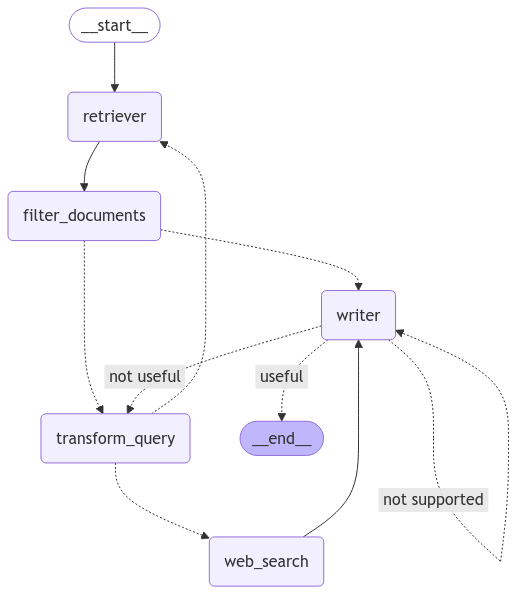

In [6]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
# Run
inputs = {"question": "코스피와 코스닥에 대한 최근 이슈에 대한 인사이트를 작성해줘"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

[Graph Log] RETRIEVE ...


c:\SKN05-FINAL-3TEAM\model\finpilot\vectorstore.py:36: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


Node 'retriever':

---

[Graph Log] FILTER DOCUMENTS ...
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Graph Log] DETERMINES 'WRITE' OR 'REWRITE QUESTION' ...
[Graph Log] DECISION : REWRITE QUESTION
Node 'filter_documents':

---

[Graph Log] TRANSFORM QUERY ...
[Graph Log] DETERMINES 'RETRIEVE' OR 'WEB SEARCH' ...
[Graph Log] DECISION : WEB SEARCH
Node 'transform_query':

---

[Graph Log] WEB SEARCH ...
Node 'web_search':

---

[Graph Log] WRITE ...
[Graph Log] CHECK HALLUCINATIONS ...
[Graph Log] DECISION : ANSWER IS GROUNDED IN DOCUMENTS
[Graph Log] CHECK ANSWER IS USEFUL OR NOT ...
[Graph Log] DECISION : GENERATION ADDRESSES QUESTION
Node 'writer':

---

최근 코스피는 외국인과 기관투자자의 매수 덕분에 2440선을 회복하며 2444.70을 기록하고 있습니다. 코스닥 지수는 700선을 탈환하며 700.40에 도달했으며, 기관의 매수세가 두드러집니다. 전반적으로 국내 증시는 상승세를 보이고 있습니다.


In [8]:
print(value["messages"])
print(len(value["messages"]))

[HumanMessage(content='최근 코스피와 코스닥의 주요 이슈 및 동향에 대한 인사이트를 제공해줄 수 있나요?', additional_kwargs={}, response_metadata={}, id='bc094088-c0d1-4f44-a78a-0e99505eade1'), AIMessage(content='최근 코스피는 외국인과 기관투자자의 매수 덕분에 2440선을 회복하며 2444.70을 기록하고 있습니다. 코스닥 지수는 700선을 탈환하며 700.40에 도달했으며, 기관의 매수세가 두드러집니다. 전반적으로 국내 증시는 상승세를 보이고 있습니다.', additional_kwargs={}, response_metadata={}, id='00171257-a472-4e3d-bac1-fe30e193dcdc')]
2


### 3-3. Text Magician

In [4]:
from finpilot.text_magician import text_magician_node

In [5]:
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("text_magician", text_magician_node)

# Add Edges
workflow.add_edge(START, "text_magician")
workflow.add_edge("text_magician", END)

app = workflow.compile()

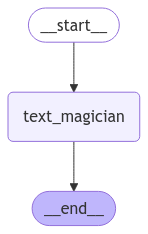

In [6]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
inputs = {"question" : """
    최근 코스피는 외국인과 기관투자자의 매수 덕분에 2440선을 회복하며 2444.70을 기록했습니다. 코스닥 지수는 장중 2% 상승하여 700선을 탈환했습니다. 전반적으로 국내 증시는 상승세를 보이고 있습니다
    
    이 텍스트를 확장해줘
"""}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

[Graph Log] TEXT_MAGICIAN ...
Node 'text_magician':

---

최근 한국의 주식 시장에서 긍정적인 흐름이 이어지고 있습니다. 코스피 지수는 외국인과 기관투자자들의 활발한 매수세에 힘입어 2440선을 회복하며 2444.70을 기록했습니다. 이는 투자자들의 신뢰가 회복되고 있다는 신호로 해석될 수 있습니다. 외국인 투자자들은 특히 대형주에 대한 관심을 보이며, 안정적인 수익을 추구하는 경향이 강해지고 있습니다.

한편, 코스닥 지수 또한 장중 2% 상승하며 700선을 탈환했습니다. 이는 기술주와 중소형주들이 강세를 보인 결과로, 투자자들은 성장 가능성이 높은 기업들에 대한 관심을 더욱 높이고 있는 것으로 보입니다. 이러한 상승세는 글로벌 경제의 회복세와 함께 국내 기업들의 실적 개선 기대감이 반영된 결과일 수 있습니다.

전반적으로 국내 증시는 상승세를 보이며, 시장의 분위기가 긍정적으로 전환되고 있습니다. 전문가들은 이러한 흐름이 지속될 가능성이 있다고 전망하며, 투자자들에게는 보다 신중한 접근이 필요하다고 조언하고 있습니다. 특히, 글로벌 경제 상황이나 금리 변화 등 외부 요인에 대한 모니터링이 중요하다는 점을 강조하고 있습니다. 

이와 함께, 투자자들은 각종 경제 지표와 기업 실적 발표를 주의 깊게 살펴보아야 하며, 시장의 변동성에 대비한 전략을 세우는 것이 필요할 것입니다. 이러한 시장 상황 속에서, 투자자들은 보다 다양한 투자 기회를 모색할 수 있을 것으로 기대됩니다.


In [8]:
print(value["messages"])
print(len(value["messages"]))

[HumanMessage(content='\n    최근 코스피는 외국인과 기관투자자의 매수 덕분에 2440선을 회복하며 2444.70을 기록했습니다. 코스닥 지수는 장중 2% 상승하여 700선을 탈환했습니다. 전반적으로 국내 증시는 상승세를 보이고 있습니다\n    \n    이 텍스트를 확장해줘\n', additional_kwargs={}, response_metadata={}, id='1b9daa70-78d1-4b92-bfe9-f547a5b3b164'), AIMessage(content='최근 한국의 주식 시장에서 긍정적인 흐름이 이어지고 있습니다. 코스피 지수는 외국인과 기관투자자들의 활발한 매수세에 힘입어 2440선을 회복하며 2444.70을 기록했습니다. 이는 투자자들의 신뢰가 회복되고 있다는 신호로 해석될 수 있습니다. 외국인 투자자들은 특히 대형주에 대한 관심을 보이며, 안정적인 수익을 추구하는 경향이 강해지고 있습니다.\n\n한편, 코스닥 지수 또한 장중 2% 상승하며 700선을 탈환했습니다. 이는 기술주와 중소형주들이 강세를 보인 결과로, 투자자들은 성장 가능성이 높은 기업들에 대한 관심을 더욱 높이고 있는 것으로 보입니다. 이러한 상승세는 글로벌 경제의 회복세와 함께 국내 기업들의 실적 개선 기대감이 반영된 결과일 수 있습니다.\n\n전반적으로 국내 증시는 상승세를 보이며, 시장의 분위기가 긍정적으로 전환되고 있습니다. 전문가들은 이러한 흐름이 지속될 가능성이 있다고 전망하며, 투자자들에게는 보다 신중한 접근이 필요하다고 조언하고 있습니다. 특히, 글로벌 경제 상황이나 금리 변화 등 외부 요인에 대한 모니터링이 중요하다는 점을 강조하고 있습니다. \n\n이와 함께, 투자자들은 각종 경제 지표와 기업 실적 발표를 주의 깊게 살펴보아야 하며, 시장의 변동성에 대비한 전략을 세우는 것이 필요할 것입니다. 이러한 시장 상황 속에서, 투자자들은 보다 다양한 투자 기회를 모색할 수 있을 것으로 기대됩니다.', additional_kwargs={}, r

In [9]:
texts = """
최근 한국의 주식 시장은 외국인 투자자와 기관 투자자들의 활발한 매수세 덕분에 긍정적인 흐름을 보이고 있습니다. 특히 코스피 지수는 2440선을 회복하며 2444.70을 기록했습니다. 이는 투자자들의 신뢰가 회복되고 있다는 신호로 해석될 수 있습니다. 외국인과 기관의 매수는 시장에 유동성을 공급하고, 이는 주가 상승에 긍정적인 영향을 미치고 있습니다.

코스닥 지수 또한 장중 2% 상승하여 700선을 탈환하는 성과를 올렸습니다. 코스닥 시장의 상승은 기술주 및 중소형주에 대한 투자 심리가 개선되었음을 나타내며, 이는 전체 시장에 긍정적인 영향을 미치는 요소로 작용하고 있습니다. 투자자들은 기업 실적 개선, 글로벌 경제 회복, 그리고 정부의 정책 지원 등 다양한 긍정적인 요인들을 반영하여 적극적으로 매수에 나서고 있는 것으로 보입니다.

전반적으로 국내 증시는 상승세를 보이며 투자자들의 기대감을 높이고 있습니다. 이러한 상승세는 앞으로의 경제 전망에 대한 긍정적인 신호로 해석될 수 있으며, 앞으로도 외국인과 기관의 지속적인 매수가 이어질 경우, 시장의 추가 상승 가능성도 열려 있습니다. 따라서 투자자들은 시장의 흐름을 주의 깊게 살펴보며, 적절한 투자 전략을 세우는 것이 중요할 것으로 보입니다.
"""

inputs = {"question" : texts + "\n 이 내용을 요약해줘"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

[Graph Log] TEXT_MAGICIAN ...
Node 'text_magician':

---

최근 한국 주식 시장은 외국인 및 기관 투자자들의 활발한 매수세 덕분에 긍정적인 흐름을 보이고 있습니다. 코스피 지수는 2440선을 회복하며 2444.70을 기록했고, 코스닥 지수는 2% 상승하여 700선을 탈환했습니다. 이는 투자자들의 신뢰 회복과 기술주 및 중소형주에 대한 긍정적인 투자 심리를 반영합니다. 기업 실적 개선, 글로벌 경제 회복, 정부의 정책 지원 등이 매수에 긍정적인 영향을 미치고 있으며, 이러한 상승세는 앞으로의 경제 전망에 대한 기대감을 높이고 있습니다. 따라서 투자자들은 시장 흐름을 주의 깊게 살펴보며 적절한 투자 전략을 세우는 것이 중요합니다.


In [10]:
print(value["messages"])
print(len(value["messages"]))

[HumanMessage(content='\n최근 한국의 주식 시장은 외국인 투자자와 기관 투자자들의 활발한 매수세 덕분에 긍정적인 흐름을 보이고 있습니다. 특히 코스피 지수는 2440선을 회복하며 2444.70을 기록했습니다. 이는 투자자들의 신뢰가 회복되고 있다는 신호로 해석될 수 있습니다. 외국인과 기관의 매수는 시장에 유동성을 공급하고, 이는 주가 상승에 긍정적인 영향을 미치고 있습니다.\n\n코스닥 지수 또한 장중 2% 상승하여 700선을 탈환하는 성과를 올렸습니다. 코스닥 시장의 상승은 기술주 및 중소형주에 대한 투자 심리가 개선되었음을 나타내며, 이는 전체 시장에 긍정적인 영향을 미치는 요소로 작용하고 있습니다. 투자자들은 기업 실적 개선, 글로벌 경제 회복, 그리고 정부의 정책 지원 등 다양한 긍정적인 요인들을 반영하여 적극적으로 매수에 나서고 있는 것으로 보입니다.\n\n전반적으로 국내 증시는 상승세를 보이며 투자자들의 기대감을 높이고 있습니다. 이러한 상승세는 앞으로의 경제 전망에 대한 긍정적인 신호로 해석될 수 있으며, 앞으로도 외국인과 기관의 지속적인 매수가 이어질 경우, 시장의 추가 상승 가능성도 열려 있습니다. 따라서 투자자들은 시장의 흐름을 주의 깊게 살펴보며, 적절한 투자 전략을 세우는 것이 중요할 것으로 보입니다.\n\n 이 내용을 요약해줘', additional_kwargs={}, response_metadata={}, id='944002e9-e76c-4c07-994c-eb95de1e9689'), AIMessage(content='최근 한국 주식 시장은 외국인 및 기관 투자자들의 활발한 매수세 덕분에 긍정적인 흐름을 보이고 있습니다. 코스피 지수는 2440선을 회복하며 2444.70을 기록했고, 코스닥 지수는 2% 상승하여 700선을 탈환했습니다. 이는 투자자들의 신뢰 회복과 기술주 및 중소형주에 대한 긍정적인 투자 심리를 반영합니다. 기업 실적 개선, 글로벌 경제 회복, 정부의 정책 지원 등이 매수에 긍정적인 영향을 미치고 있